In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter

from operator import attrgetter

In [2]:
# load data
master = pd.read_csv('../data/processed/master_data.csv', engine='pyarrow')
rfm = pd.read_csv('../data/model/rfm_data.csv', engine='pyarrow')
guide = pd.read_excel('../data/additional/rfm-guide.xlsx').reset_index()
guide.rename(columns={'index':'level', 'Segment':'RFM_segment'}, inplace=True)

# merge data
data_segm = master.merge(rfm, on='customer_unique_id')
data_segm = data_segm.merge(guide, on='RFM_segment')

In [3]:
guide = pd.read_excel('../data/additional/rfm-guide.xlsx').reset_index()
guide.rename(columns={'index':'level'}, inplace=True)

## **4. Data Analysis - Cluster**

Setelah segmentasi dilakukan, selanjutnya akan dilakukan data analysis untuk mengetahui karakteristik dari tiap segmen yang akan terpakai untuk dasar pembuatan rekomendasi marketing

### **4.1 Pareto Cluster**

In [4]:
eda_rfm = rfm.merge(guide, left_on='RFM_segment', right_on='Segment')
par = pd.DataFrame(eda_rfm.groupby('RFM_segment')['customer_unique_id'].nunique().sort_values(ascending=False))
par.rename(columns={'customer_unique_id':'n_customers'}, inplace=True)
par['%'] = par['n_customers']/par.values.sum()*100
par['%_cumm'] = par['n_customers'].cumsum()/par.values.sum()*100
par.rename(columns={'customer_unique_id':'n_customers'}, inplace=True)
par

,n_customers,%,%_cumm
RFM_segment,,,
Promising,35060,36.486627,36.448695
New Customers,18861,19.628473,56.056763
Cannot Lose Them,18654,19.413050,75.449631
Lost Customers,8018,8.344261,83.785217
Hibernating Customers,7849,8.168384,91.945109
About To Sleep,7539,7.845770,99.782722
At Risk,66,0.068686,99.851336
Need Attention,34,0.035383,99.886683
Loyal,5,0.005203,99.891881


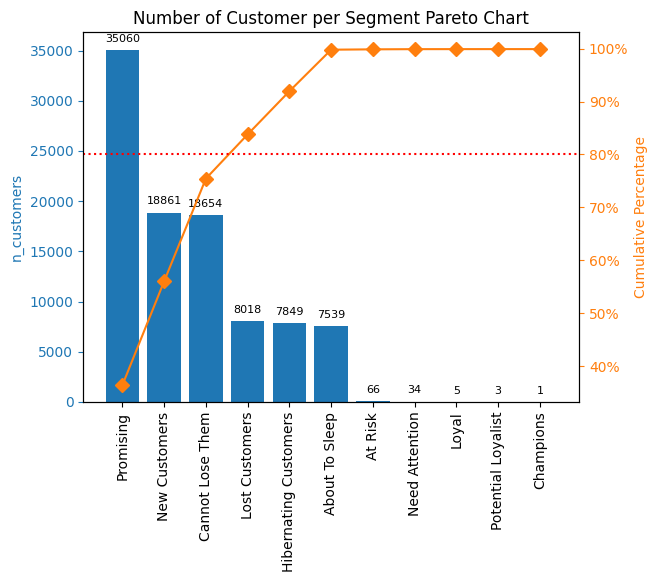

In [5]:
fig, ax = plt.subplots()
ax.bar(par.index, par["n_customers"], color="C0")
ax2 = ax.twinx()
ax2.plot(par.index, par["%_cumm"], color="C1", marker="D", ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())

# Iterating over the bars one-by-one
for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.0f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=8, xytext=(0, 8),
                   textcoords='offset points')

# Iterating over the bars one-by-one
for dot in ax2.patches:
    ax2.annotate(format(dot.get_height(), '.0f'), 
                   (dot.get_x() + dot.get_width() / 2, 
                    dot.get_height()), ha='center', va='center',
                   size=8, xytext=(0, 8),
                   textcoords='offset points')


ax.tick_params(axis="y", colors="C0")
ax2.tick_params(axis="y", colors="C1")

ax.tick_params(axis="x", labelrotation = 90)

ax.set_ylabel('n_customers', color='C0')
ax2.set_ylabel('Cumulative Percentage', color='C1')

plt.axhline(80, color='red', linestyle=':')
plt.title('Number of Customer per Segment Pareto Chart')
plt.show()

**Insights**:

* Berdasarkan grafik diatas, 75% customer olist terpusat di 3 segment: Promising (36.4%), New Customers (19.6%), dan Cannot Lose Them (19.4%)
Oleh karena itu Analisis karakteristik akan difokuskan ke 3 segment tersebut

In [6]:
top_segment = par.index[:3]

### **4.2 RFM**

#### **4.2.1 Recency**

In [7]:
eda_rfm[eda_rfm.RFM_segment.isin(top_segment)].groupby(['level','RFM_segment'])['recency'].describe()

,,count,mean,std,min,25%,50%,75%,max
level,RFM_segment,,,,,,,,
3,New Customers,18861.0,120.109167,71.625530,1.0,58.0,119.0,173.0,271.0
4,Promising,35060.0,136.480633,75.824409,2.0,72.0,136.0,199.0,271.0
7,Cannot Lose Them,18654.0,414.212930,94.590087,272.0,331.0,411.0,483.0,726.0


In [8]:
eda_rfm[eda_rfm.RFM_segment.isin(top_segment)].groupby(['level','RFM_segment'])['R'].describe()

,,count,mean,std,min,25%,50%,75%,max
level,RFM_segment,,,,,,,,
3,New Customers,18861.0,4.188749,0.756311,3.0,4.0,4.0,5.0,5.0
4,Promising,35060.0,4.013548,0.812573,3.0,3.0,4.0,5.0,5.0
7,Cannot Lose Them,18654.0,1.406669,0.491225,1.0,1.0,1.0,2.0,2.0


#### **4.2.2 Frequency**

In [9]:
eda_rfm[eda_rfm.RFM_segment.isin(top_segment)].groupby(['level','RFM_segment'])['frequency'].describe()

,,count,mean,std,min,25%,50%,75%,max
level,RFM_segment,,,,,,,,
3,New Customers,18861.0,1.004401,0.066193,1.0,1.0,1.0,1.0,2.0
4,Promising,35060.0,1.055533,0.253944,1.0,1.0,1.0,1.0,5.0
7,Cannot Lose Them,18654.0,1.042725,0.202243,1.0,1.0,1.0,1.0,2.0


In [10]:
eda_rfm[eda_rfm.RFM_segment.isin(top_segment)].groupby(['level','RFM_segment'])['F'].describe()

,,count,mean,std,min,25%,50%,75%,max
level,RFM_segment,,,,,,,,
3,New Customers,18861.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
4,Promising,35060.0,1.003736,0.061013,1.0,1.0,1.0,1.0,2.0
7,Cannot Lose Them,18654.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0


#### **4.2.3 Monetary**

In [11]:
eda_rfm[eda_rfm.RFM_segment.isin(top_segment)].groupby(['level','RFM_segment'])['monetary'].describe()

,,count,mean,std,min,25%,50%,75%,max
level,RFM_segment,,,,,,,,
3,New Customers,18861.0,51.671949,17.813942,0.00,37.4700,49.540,66.1300,87.54
4,Promising,35060.0,237.574162,261.714416,87.56,119.3700,163.775,244.8025,9553.02
7,Cannot Lose Them,18654.0,272.343666,312.606531,87.57,139.2825,184.940,286.0900,13664.08


In [12]:
eda_rfm[eda_rfm.RFM_segment.isin(top_segment)].groupby(['level','RFM_segment'])['M'].describe()

,,count,mean,std,min,25%,50%,75%,max
level,RFM_segment,,,,,,,,
3,New Customers,18861.0,1.387996,0.487307,1.0,1.0,1.0,2.0,2.0
4,Promising,35060.0,3.996178,0.810797,3.0,3.0,4.0,5.0,5.0
7,Cannot Lose Them,18654.0,4.207891,0.756033,3.0,4.0,4.0,5.0,5.0


**Insights**:

Berdasarkan analisis dari 3 fitur RFM dapat diambil kesimpulan bahwa:
1. Promising : Customer yang berbelanja belum lama, frequency yang tidak terlalu jarang, dan nilai belanja nya tinggi.
2. New Customers : Customer yang baru saja berbelanja
3. Cannot Lose Them : Customer yang sudah tidak berbelanja lama, frequency yang rendah, tapi memiliki nilai belanja yang tinggi. 

### **4.3 Customer Behaviour**

#### **4.3.1 Waktu Pembelian**

In [13]:
data_segm['day_num'] = data_segm.order_purchase_timestamp.dt.weekday
data_segm['day_name'] = data_segm.order_purchase_timestamp.dt.strftime('%A')

In [14]:
day = data_segm.groupby(['RFM_segment','level','day_num','day_name'])['customer_unique_id']\
    .nunique().reset_index()\
    .rename(columns={'customer_unique_id': 'n_customers','product_category_name_english':'product'})

day['proportion_n_cust'] = day.n_customers/day.groupby(['RFM_segment'])['n_customers'].transform(sum)*100

daypiv = day.pivot_table(index=['level','RFM_segment'], columns=['day_num','day_name'], values='proportion_n_cust').sort_index(level='level', ascending=False)

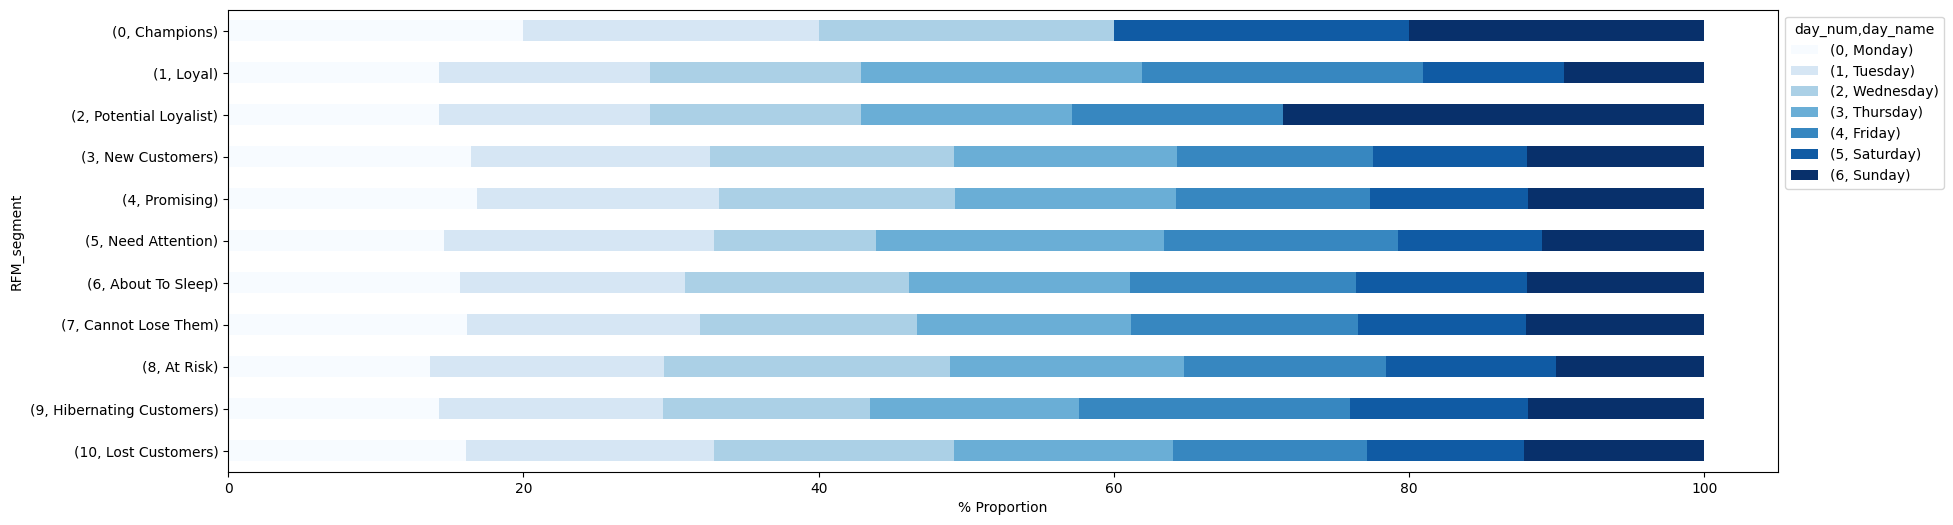

In [15]:
# setting the dimensions of the plot
fig, ax = plt.subplots(figsize=(20, 6))
 
# drawing the plot
daypiv.plot(kind='barh',stacked=True, colormap='Blues',rot=90, ax=ax)

ax.tick_params(axis='y', rotation=0)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set(xlabel='% Proportion', ylabel='RFM_segment')

plt.show()

**Insights**:

* Berdasarkan grafik diatas, pelanggan olist yang termasuk ke dalam segmen New Customers, Promising, dan Cannot Lose Them paling banyak berbelanja pada hari Senin dan Selasa

#### **4.3.2 State**

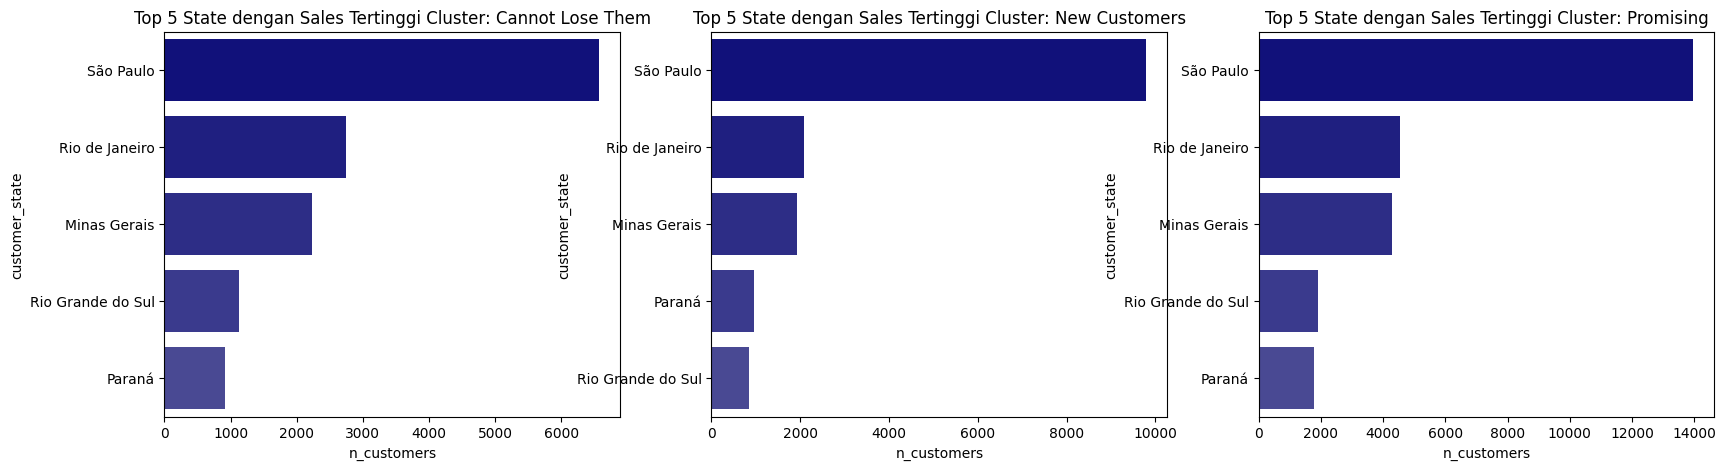

In [16]:
state = data_segm[data_segm.RFM_segment.isin(top_segment)].groupby(['RFM_segment','customer_state'])['customer_unique_id'].nunique().reset_index().rename(columns={'customer_unique_id': 'n_customers'})

segm = state.RFM_segment.unique()

# Viz
c1 = sns.blend_palette(['darkblue', 'lightgrey'], 15)
fig, axes = plt.subplots(1,len(segm), figsize=(20, 5))
for i, val in enumerate(segm):
    sns.barplot(data=state.query(f"RFM_segment == '{val}'").nlargest(5, columns='n_customers'), x = 'n_customers', y='customer_state', palette=c1, ax=axes[i])
    axes[i].title.set_text(f'Top 5 State dengan Sales Tertinggi Cluster: {val}')

# plt.show()


**Insights**:

Customer pada segment Promising, New Customers, dan Cannot Lose Them secara umum terpusat pada 3 State:
- Sao Paulo
- Rio de Janeiro
- Minas Gerais

#### **4.3.3 Produk**

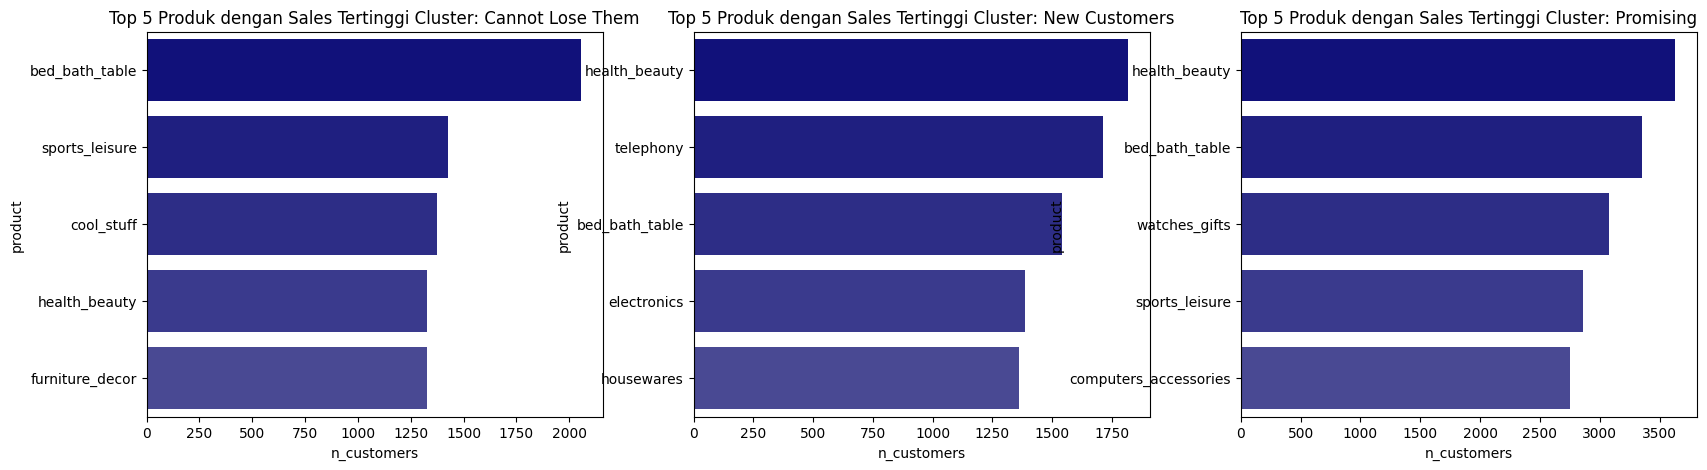

In [17]:
prod = data_segm[data_segm.RFM_segment.isin(top_segment)].groupby(['RFM_segment','product_category_name_english'])['customer_unique_id'].nunique().reset_index().rename(columns={'customer_unique_id': 'n_customers','product_category_name_english':'product'})

segm = prod.RFM_segment.unique()

# Viz
c1 = sns.blend_palette(['darkblue', 'lightgrey'], 15)
fig, axes = plt.subplots(1,len(segm), figsize=(20, 5))
for i, val in enumerate(segm):
    sns.barplot(data=prod.query(f"RFM_segment == '{val}'").nlargest(5, columns='n_customers'), x = 'n_customers', y='product', palette=c1, ax=axes[i])
    axes[i].title.set_text(f'Top 5 Produk dengan Sales Tertinggi Cluster: {val}')

# plt.show()

**Insights**:

* Berdasarkan grafik diatas, 5 produk yang sering dibeli oleh pelanggan olist yang termasuk ke dalam segmen Cannot Lose Them yaitu bed_bath_table, sports_leisure, cool_stuff, health_beauty, dan furniture_decor
* Berdasarkan grafik diatas, 5 produk yang sering dibeli oleh pelanggan olist yang termasuk ke dalam segmen New Customers yaitu health_beauty, telephony, bed_bath_table, electronics, dan housewares
* Berdasarkan grafik diatas, 5 produk yang sering dibeli oleh pelanggan olist yang termasuk ke dalam segmen Promising yaitu health_beauty, bed_bath_table, watches_gifts, sport_leisure, dan computers_accessories

#### **4.3.4 Payment Type**

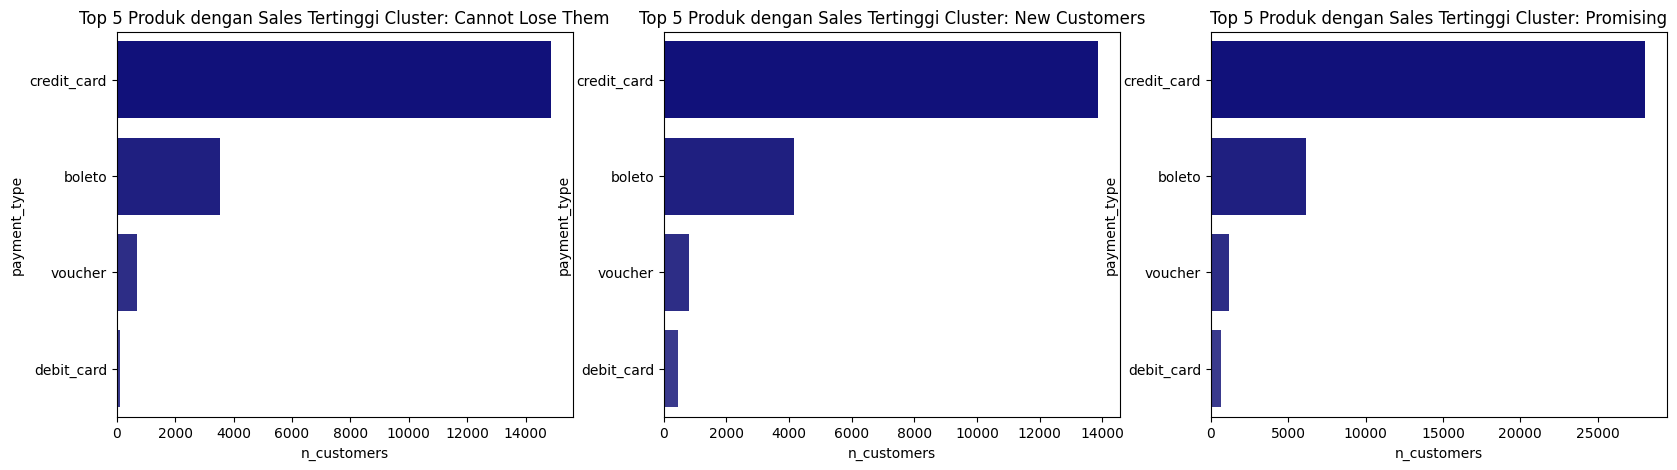

In [18]:
prod = data_segm[data_segm.RFM_segment.isin(top_segment)].groupby(['RFM_segment','payment_type'])['customer_unique_id'].nunique().reset_index().rename(columns={'customer_unique_id': 'n_customers'})

segm = prod.RFM_segment.unique()

# Viz
c1 = sns.blend_palette(['darkblue', 'lightgrey'], 15)
fig, axes = plt.subplots(1,len(segm), figsize=(20, 5))
for i, val in enumerate(segm):
    sns.barplot(data=prod.query(f"RFM_segment == '{val}'").nlargest(5, columns='n_customers'), x = 'n_customers', y='payment_type', palette=c1, ax=axes[i])
    axes[i].title.set_text(f'Top 5 Produk dengan Sales Tertinggi Cluster: {val}')

# plt.show()

**Insights**:

* Berdasarkan grafik diatas, pelanggan olist yang termasuk ke dalam segmen Cannot Lose Them, New Customers, dan Promising lebih banyak melakukan pembayaran menggunakan credit card

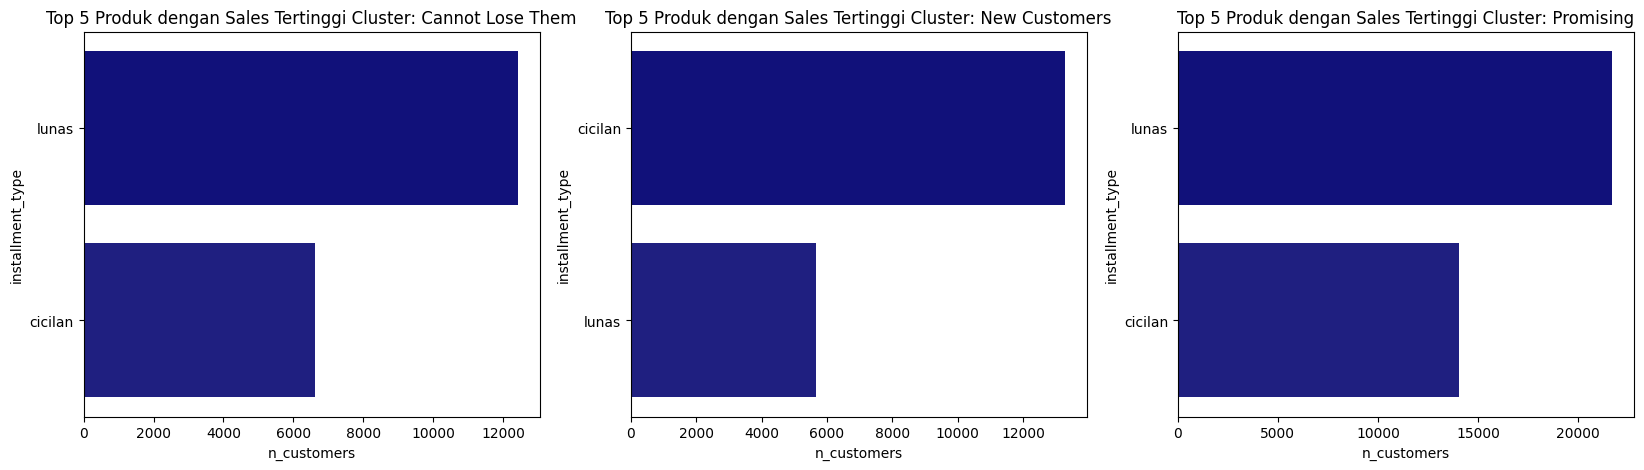

In [19]:
data_segm['installment_type'] = data_segm['payment_installments'].apply(lambda x: 'lunas' if x > 1 else 'cicilan')

prod = data_segm[data_segm.RFM_segment.isin(top_segment)].groupby(['RFM_segment','installment_type'])['customer_unique_id'].nunique().reset_index().rename(columns={'customer_unique_id': 'n_customers'})

segm = prod.RFM_segment.unique()

# Viz
c1 = sns.blend_palette(['darkblue', 'lightgrey'], 15)
fig, axes = plt.subplots(1,len(segm), figsize=(20, 5))
for i, val in enumerate(segm):
    sns.barplot(data=prod.query(f"RFM_segment == '{val}'").nlargest(5, columns='n_customers'), x = 'n_customers', y='installment_type', palette=c1, ax=axes[i])
    axes[i].title.set_text(f'Top 5 Produk dengan Sales Tertinggi Cluster: {val}')

# plt.show()


**Insights**:

* Berdasarkan grafik diatas, pelanggan olist yang termasuk ke dalam segmen Cannot Lose Them dan Promising lebih banyak melakukan pembayaran secara lunas, 
* Sementara itu pelanggan olist yang termasuk ke dalam segmen New Customers lebih banyak melakukan pembayaran secara cicilan

#### **4.3.5 Rating**

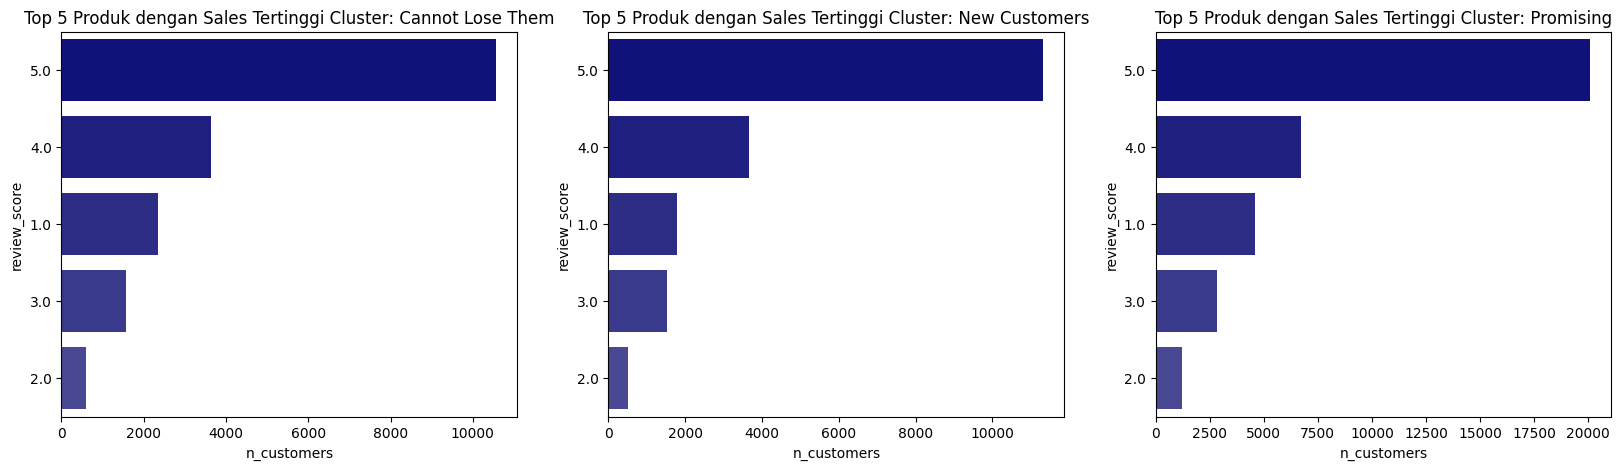

In [20]:
prod = data_segm[data_segm.RFM_segment.isin(top_segment)].groupby(['RFM_segment','review_score'])['customer_unique_id'].nunique().reset_index().rename(columns={'customer_unique_id': 'n_customers'})

segm = prod.RFM_segment.unique()

# Viz
c1 = sns.blend_palette(['darkblue', 'lightgrey'], 15)
fig, axes = plt.subplots(1,len(segm), figsize=(20, 5))
for i, val in enumerate(segm):
    sns.barplot(data=prod.query(f"RFM_segment == '{val}'").nlargest(5, columns='n_customers'), x = 'n_customers', y='review_score', palette=c1, ax=axes[i])
    axes[i].title.set_text(f'Top 5 Produk dengan Sales Tertinggi Cluster: {val}')

# plt.show()


**Insights**:

* Berdasarkan grafik diatas, pelanggan olist yang termasuk ke dalam segmen Cannot Lose Them, New Customers, dan Promising lebih banyak memberikan ulasan skor pemesanan produk yang bernilai 5